### [프로젝트 : 주식 예측에 도전해 보자]  

## [삼성전자 주가]
 
- 대한민국 대장주 삼성전자에 대한 주식 시세를 예측  
  데이터는 과거의 일자별 시세  
  
  
- 데이터 다운받을 링크  
[Yahoo Finance](https://finance.yahoo.com/?guccounter=1)  
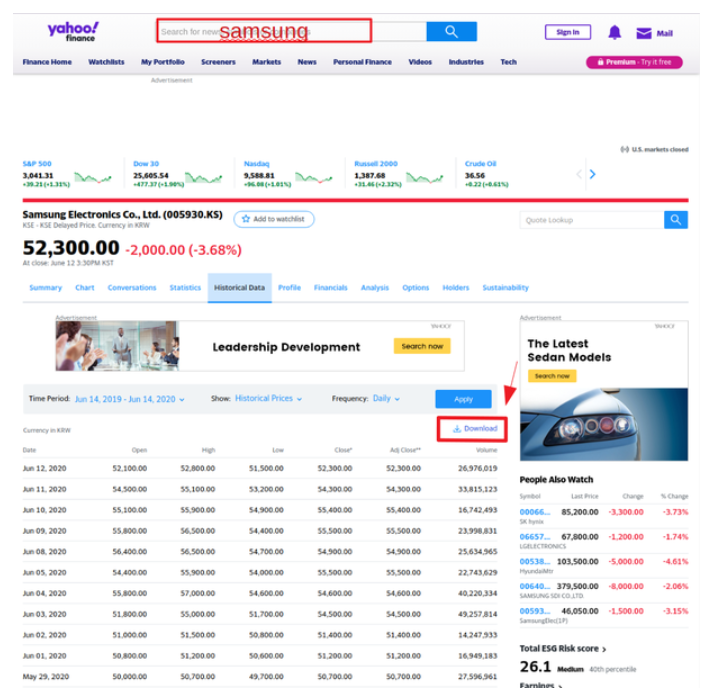  

- 클라우드에 있는 주소  
  ~/aiffel/stock_prediction/data  
  005930.KS.csv 
  
  
- 데이터셋 설명  
  1) 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
  2) 날짜별로  
     -> 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장  
     -> 이번 프로젝트에서는 종가(Close)만 사용

(주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

### STEP 1. 시계열 데이터 준비  


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams

#import warnings
#warnings.filterwarnings('ignore')

# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel//stock_prediction/data/005930.KS.csv' 
#인덱스를 date로 두고 파일을 불러옴  
#parse_dates=True : 해당 컬럼을 datetime(날짜)형태로 바꾸겠다는 의미
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True) 
#Series 객체 생성= ts
#Series는 데이터 프레임에서 하나의 열만 가져온 것 <- 여기선 Close 컬럼(열) 가져옴
#Series 인덱스 구조 동일하게 많은 라이브러리에서 호환해서 지원해주는데 간혹 에러 생겨서
ts1 = df['Close']

print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

-----
### STEP 2. 각종 전처리 수행

#### 1. 결측치 처리

##### 1) 결측치 유무 확인

In [8]:
# 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.
ts1[ts1.isna()] 

Series([], Name: Close, dtype: float64)

- 결측치 없는 것 확인  


- 만약 결측치가 있었다면?  
  1) 결측치가 있는 데이터를 모두 삭제(drop)  
  2) 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입  
  ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식  
  

#### 2. 로그 변환  
- 우리는 애초에 이 데이터가 안정적이지 않다는 귀무가설을 세움  
  그렇기 때문에 안정적인(Stationary) 데이터 가공해야함  
  
  
- 시간추이에 따라 분산이 점점 커지고 있을 것이기 때문에  
  로그함수로 변환해서 시간추이에 따른 분산을 일정하게 만듦  

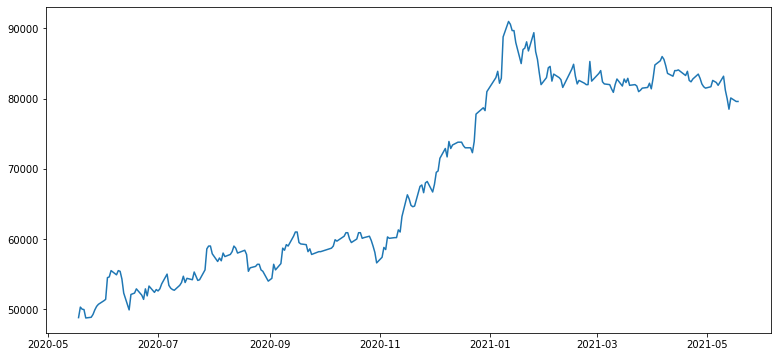

In [9]:
#기존 데이터셋 plot
plt.plot(ts1)

#시간 추이에 따라 계속 증가함  

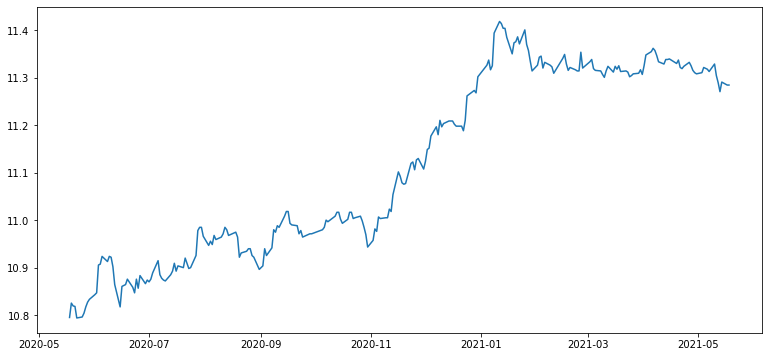

In [10]:
# 로그 변환 데이터셋 plot
ts1_log = np.log(ts1)
plt.plot(ts1_log)

### STEP 3. 시계열 안정성 분석  

### 1. 정성적 그래프 분석  


##### 1) 기본 시각화

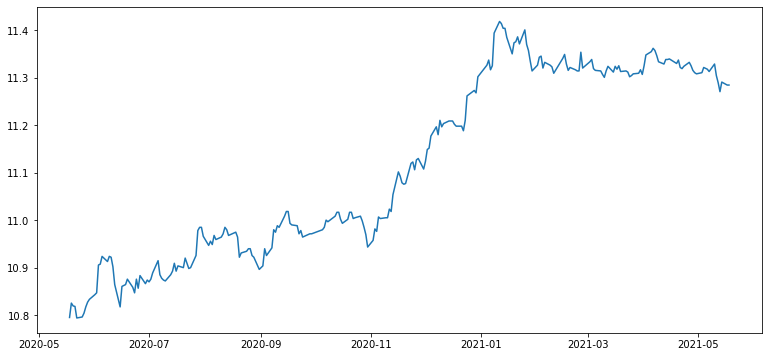

In [11]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6   
# 시계열(time series) 데이터를 차트로 그림
plt.plot(ts1_log)

- 시간에 따라 평균, 분산이 지속적으로 커지는 패턴이 보임  
- 패턴이 눈에 띄게 잘 보이는 편이 아님  


##### 2) 통계적 특성 명료하게 시각화  
평균, 분산, 자기공분산의 패턴 명료히 시각화  

- 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수  
  일정 시간 내 구간 = 현재 타임스텝 ~ window에 주어진 타임스텝 이전 사이  
  1) 구간의 평균(rolling mean, 이동평균)과  
  2) 표준편차(rolling std, 이동표준편차)를  
  원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있음  
  
  
- 이동평균  
  = 수의 집합에서 특정 크기의 부분 집합을 연속적으로 이동하며 산출한 평균  
  [이동평균 설명 링크](https://www.econowide.com/3544)  
  

- Q1. 다음 데이터에서 window 크기가 2인 이동평균을 구해보자  
  [2, 8, 6, 10, 4]  
  -> 크기 2인 부분 집합 순차적으로 만들어서, 평균 구하기  
  -> A : 이동평균: [5, 7, 8, 7]   

In [12]:
#window = 값 : window 사이즈 설정 = 한번에 받을 수 있는 데이터의 양
def plot_rolling_statistics(timeseries, window=20):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

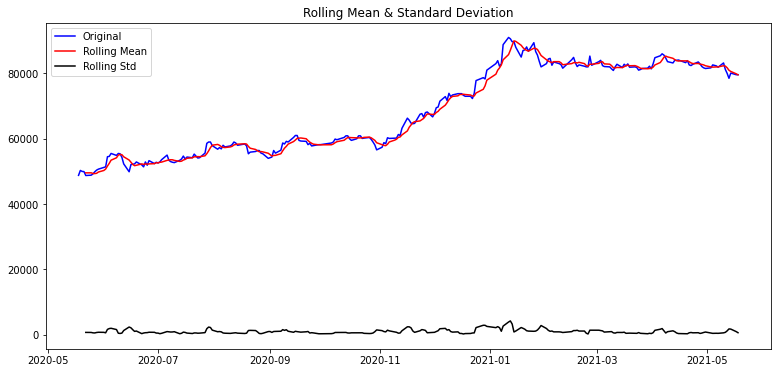

In [13]:
#일주일 구간 (근데 주말은 데이터에 없음)
plot_rolling_statistics(ts1, window=5)

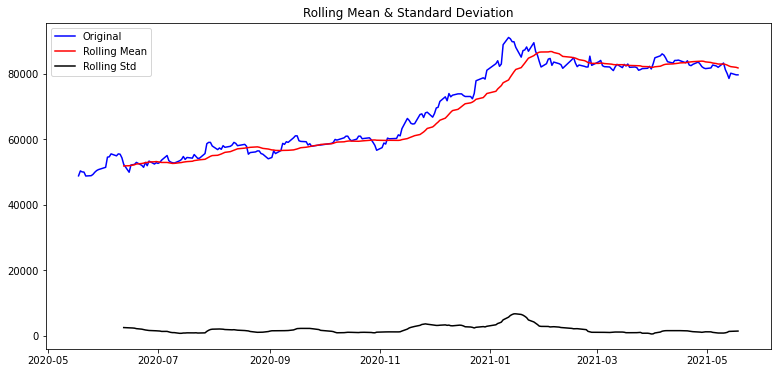

In [14]:
# 4주 (한달) 구간
plot_rolling_statistics(ts1, window=20)

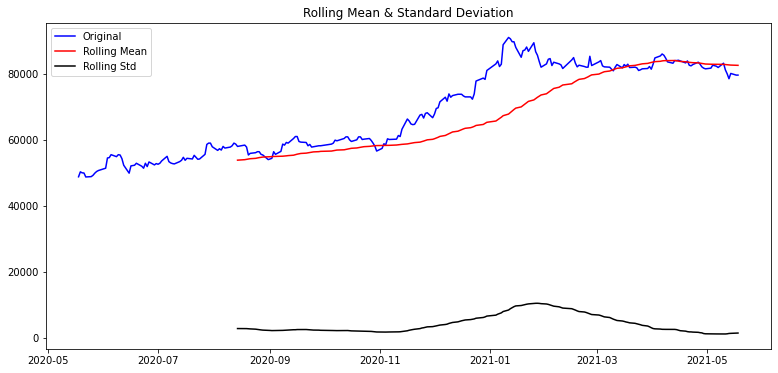

In [15]:
# 3개월 구간 
plot_rolling_statistics(ts1, window=65)

- 시간 추이에 따라 평균과 분산이 불안정해보임  
  -> 정성적 평가 말고, 정량적 평가를 해보자  
  
  
### 2. 정량적 Augmented Dicky-Fuller Test  
= 시계열 데이터 안정성을 평가법 중 통계적 방법  

### ① p-value 와 ADF test
##### 1) 해당 테스트의 step 
  일단 이 데이터 안정적이지 않다고 가정  
  -> 통계적으로 이 가정 입증해내려고 노력  
  -> 노력하다보니, 안정적이라는 것이 입증됨  
  -> 아까 내가 한 가정 틀렸구나 ! 안정적인게 맞음


  주어진 시계열 데이터가 안정적이지 않다라는 귀무가설(Null Hypothesis)를 세운 후  
  -> 통계적 가설 검정 과정을 통해 이 귀무가설이 기각될 경우  
  -> 이 시계열 데이터가 안정적이다라는 대립가설(Alternative Hypothesis)을 채택  (ADF Test의 세부 알고리즘 설명 : https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)  
  
##### 2)  통계적 가설 검정의 개본 개념 : p-value  
   - = 귀무가설의 가정이 맞다고 볼 수 있는 확률  
     = 귀무가설을 가정했을 때의 확률분포 상에서  
     현재의 관측보다 더 극단적인(정규분포의 끝단락에) 관측이 나올 확률  
     
     -> 0.05 미만으로 매우 낮게 나온다면  
     p-value만큼의 오류 가능성 하에 귀무가설을 기각하고  
     대립가설(데이터가 안정적)을 채택할 수 있는 근거가 됨  

##### 3)  statsmodels 패키지의 adfuller 메소드로 손쉽게 ADF Test 결과 이용  
   - statsmodels 패키지  
     R에서 제공하는 통계검정, 시계열분석 등을 파이썬에서도 사용 가능하게하는 강력한 통계 패키지
   - adfuller 메소드  
     주어진 timeseries에 대한 ADF Test를 수행하는 코드  
     (클라우드에는 이미 설치되어 있음)  


##### 4)  ADF Test 함수 생성


In [16]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    
    #AIC(Akaike information criterion)
    #주어진 데이터 셋에 대한 통계 모델의 상대적인 품질을 평가하는 것, 낮을수록 좋음  
    #https://m.blog.naver.com/euleekwon/221465294530
    #https://rpago.tistory.com/15
    #https://hongl.tistory.com/98
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


- Test Statistic = 검정 통계량  
   통계적 가설의 진위 여부를 검정하기 위해 표본으로 부터 계산하는 통계량  
   
   
- lag = 시차  


- Critical Value (x%)   
   귀무가설 상태에서 해당 확률이 나오게 되는 값  
   = Test Statistic 값이 Critical Value 보다 낮은 경우  
   귀무가설 확률이 낮은 상태  
   -> p-value가 낮음 = 귀무가설 기각  
   
   
- p-value  
  = 귀무가설  
  = 시계열이 안정적이지 않다는 가정  
  -> 1에 가까우면, 귀무가설 기각 못함  
  -> 0에 가까워야 안정적인 시계열이라고 할 수 있음   
  
  
- p-value = 0.590149  
  -> 0보다 1에 조금 더 가까운 값  
  -> 안정적이지 않은 시계열이라고 보여짐  
  

### ②  추세(Trend) 상쇄하기 <= Moving average 제거  
- trend  
  = 추세  
  = 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화  


- 변화량 제거 방법  
  -> Moving Average= rolling mean 거꾸로 구해서  
  -> ts_log에서 빼줌  

##### 1)  moving_avg = 구간 통계치 = 구간 평균치 구하기

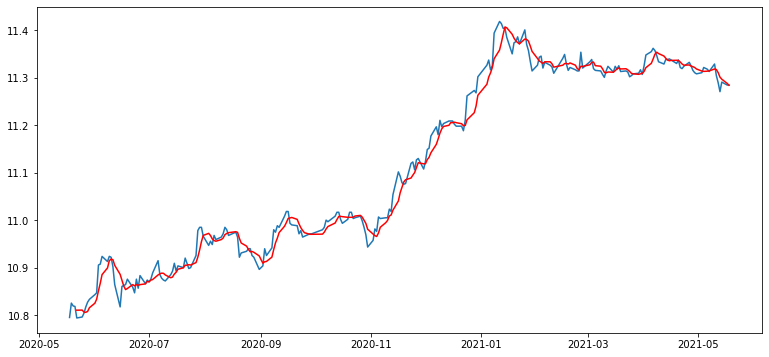

In [18]:
# 5일 구간
moving_avg_5 = ts1_log.rolling(window=5).mean()   
plt.plot(ts1_log)
plt.plot(moving_avg_5, color='red')

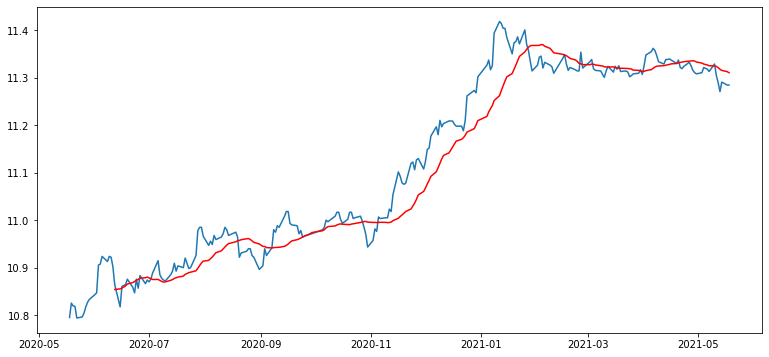

In [19]:
# 4주(한달)구간
moving_avg_20 = ts1_log.rolling(window=20).mean()   
plt.plot(ts1_log)
plt.plot(moving_avg_20, color='red')

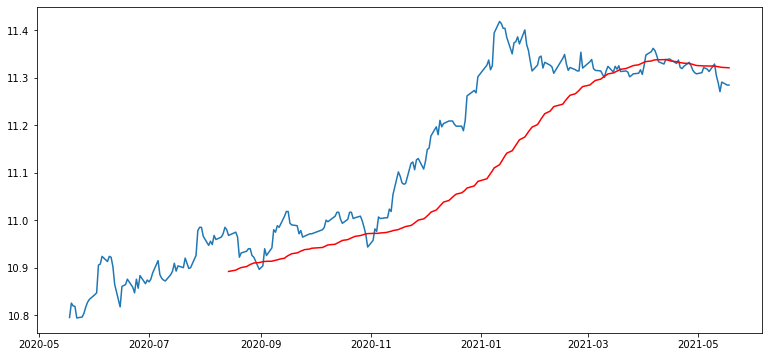

In [20]:
# 3개월 구간
moving_avg_65 = ts1_log.rolling(window=65).mean()   
plt.plot(ts1_log)
plt.plot(moving_avg_65, color='red')

 ##### 2)  moving_avg =    변화량 제거

In [21]:
#5일 구간

# ts_log = 평균치에서
# moving_avg = 구간 통계치 = 구간 평균치 = 트렌드 =추세 = 변화량 제거  
ts_log_moving_avg_5 = ts1_log - moving_avg_5
ts_log_moving_avg_5.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22   -0.016392
2020-05-25   -0.014548
2020-05-26   -0.002174
2020-05-27    0.011339
2020-05-28    0.019515
2020-05-29    0.017606
2020-06-01    0.018022
2020-06-02    0.013375
2020-06-03    0.054302
2020-06-04    0.040126
2020-06-05    0.038384
Name: Close, dtype: float64

- 구하려던 ts_log_moving_avg구함  
  -> 그런데 문제는 Moving Average 계산 시 (windows size=5인 경우)  
  앞의 64개의 데이터는 Moving Average가 계산되지 않음  
  -> ts_log_moving_avg에 결측치(NaN) 발생  
  -> 이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킴  
  -> 이를 데이터셋에서 제거  
  

In [22]:
# 4주(20일) 구간
ts_log_moving_avg_20 = ts1_log - moving_avg_20
ts_log_moving_avg_20.head(15)

Date
2020-05-18   NaN
2020-05-19   NaN
2020-05-20   NaN
2020-05-21   NaN
2020-05-22   NaN
2020-05-25   NaN
2020-05-26   NaN
2020-05-27   NaN
2020-05-28   NaN
2020-05-29   NaN
2020-06-01   NaN
2020-06-02   NaN
2020-06-03   NaN
2020-06-04   NaN
2020-06-05   NaN
Name: Close, dtype: float64

In [23]:
# 3개월 구간
ts_log_moving_avg_65 = ts1_log - moving_avg_65
ts_log_moving_avg_65.head(15)

Date
2020-05-18   NaN
2020-05-19   NaN
2020-05-20   NaN
2020-05-21   NaN
2020-05-22   NaN
2020-05-25   NaN
2020-05-26   NaN
2020-05-27   NaN
2020-05-28   NaN
2020-05-29   NaN
2020-06-01   NaN
2020-06-02   NaN
2020-06-03   NaN
2020-06-04   NaN
2020-06-05   NaN
Name: Close, dtype: float64

##### 3)결측치 제거  

In [24]:
# 5일 구간

#dropna : 결측치 제거   
#inplace=True : 원본을 수정
ts_log_moving_avg_5.dropna(inplace=True)
ts_log_moving_avg_5.head(15)

Date
2020-05-22   -0.016392
2020-05-25   -0.014548
2020-05-26   -0.002174
2020-05-27    0.011339
2020-05-28    0.019515
2020-05-29    0.017606
2020-06-01    0.018022
2020-06-02    0.013375
2020-06-03    0.054302
2020-06-04    0.040126
2020-06-05    0.038384
2020-06-08    0.013560
2020-06-09    0.009080
2020-06-10    0.004001
2020-06-11   -0.014952
Name: Close, dtype: float64

In [25]:
# 20일(4주) 구간

ts_log_moving_avg_20.dropna(inplace=True)
ts_log_moving_avg_20.head(15)

Date
2020-06-12    0.010242
2020-06-15   -0.037848
2020-06-16    0.003538
2020-06-17    0.003303
2020-06-18    0.002918
2020-06-19    0.010240
2020-06-22   -0.010044
2020-06-23   -0.023786
2020-06-24    0.002060
2020-06-25   -0.018491
2020-06-26    0.005626
2020-06-29   -0.012562
2020-06-30   -0.006301
2020-07-01   -0.008322
2020-07-02   -0.001053
Name: Close, dtype: float64

In [26]:
#3개월 구간
ts_log_moving_avg_65.dropna(inplace=True)
ts_log_moving_avg_65.head(15)

Date
2020-08-14    0.075817
2020-08-18    0.079927
2020-08-19    0.067461
2020-08-20    0.023474
2020-08-21    0.030728
2020-08-24    0.032139
2020-08-25    0.035261
2020-08-26    0.033175
2020-08-27    0.017225
2020-08-28    0.012167
2020-08-31   -0.014399
2020-09-01   -0.011578
2020-09-02   -0.008768
2020-09-03    0.026810
2020-09-04    0.012245
Name: Close, dtype: float64

- NAN 값없고, 이동 평균 모두 0과 가까워서 성공적으로 변화량 제거했다고 보여짐 

##### 4) 시각화로 정성적 평가

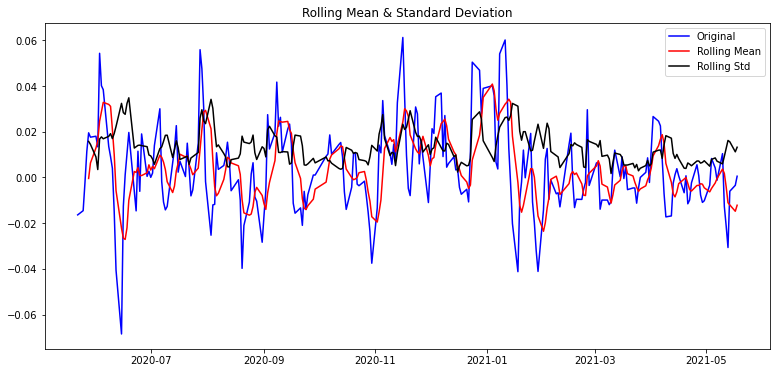

In [27]:
# 5일 구간
plot_rolling_statistics(ts_log_moving_avg_5,window=5)

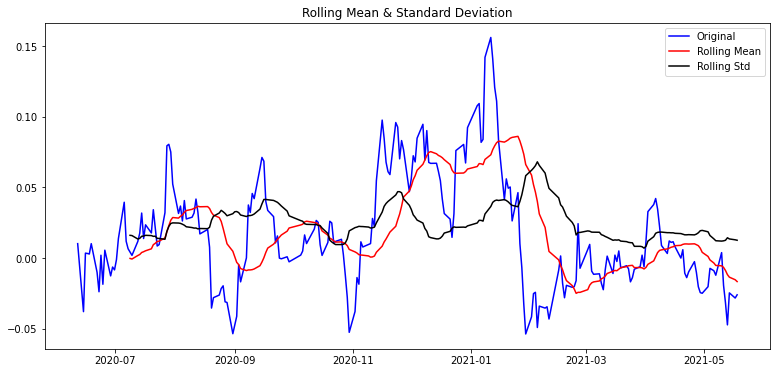

In [28]:
# 20일 구간
plot_rolling_statistics(ts_log_moving_avg_20,window=20)

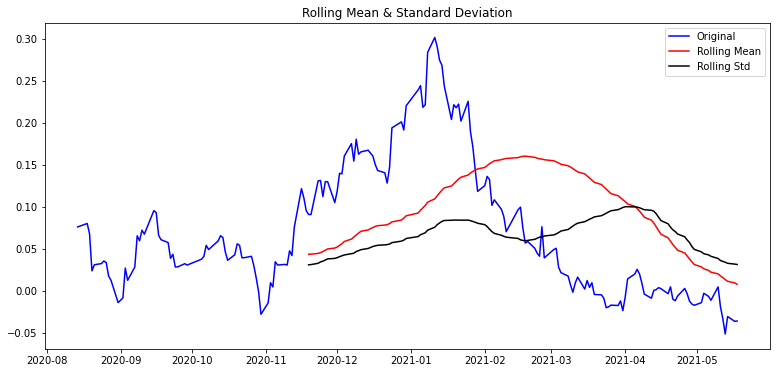

In [29]:
# 3개월 구간
plot_rolling_statistics(ts_log_moving_avg_65,window=65)

##### 5) ADF test

In [30]:
#5일 구간
augmented_dickey_fuller_test(ts_log_moving_avg_5)

Results of Dickey-Fuller Test:
Test Statistic                -7.801633e+00
p-value                        7.466367e-12
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


In [31]:
#20일 구간
augmented_dickey_fuller_test(ts_log_moving_avg_20)

Results of Dickey-Fuller Test:
Test Statistic                  -3.103759
p-value                          0.026276
#Lags Used                       0.000000
Number of Observations Used    230.000000
Critical Value (1%)             -3.459106
Critical Value (5%)             -2.874190
Critical Value (10%)            -2.573512
dtype: float64


In [32]:
#3개월 구간
augmented_dickey_fuller_test(ts_log_moving_avg_65)

Results of Dickey-Fuller Test:
Test Statistic                  -1.097313
p-value                          0.716142
#Lags Used                       0.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


- **5일, 3개월 구간**  
  p-value 값이 5일, 3개월 구간일 때는 너무 높음  
  ->  p-value = 시계열이 안정적이지 않다는 귀무가설이 기각되지 않음  
  -> **안정적인 시계열 아님**  
  
  
- **20일 구간**
  p-value= 0.026276 : 비교적 낮음  
  -> p-value = 시계열이 안정적이지 않다는 귀무가설이 기각  
  -> **안정적 시계열이라고 판단**
  **즉 20일 구간 (=window=20)일때 주기성을 가짐**
  
  
- avg vs mean  
    avg는 전체 샘플 평균  
    mean은 부분집합 or 전체 샘플 평균  
    -> "moving average를 고려할 때는 rolling mean을 구하기 위한"  
    -> 부분집합 mean 을 구해서 avg를 고려하는 것  
    -> moving_avg = ts_log.rolling(window=12).mean() 코드보면 더 직관적임

### ③ 차분(Differencing) - 계절성(Seasonality) 상쇄하기  

- 계절적/주기적 패턴  
  = 계절성(Seasonality)  
  = 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화  
  -> trend에는 포함되지 못함  
  -> 그러나 예측에 방해되는 불안정성 요소  
  (시계열 패턴 : https://otexts.com/fppkr/tspatterns.html)  
  
  
- 차분(Differencing)  
  = 계절적/주기적 패턴을 상쇄하기 위해 효과적인 방법  
  = 원래 시계열 - 한 스텝 앞으로 시프트한 시계열  
  = 이번 스텝에서 발생한 변화량 의미  
  
##### 1) 시프트한 시계열 , 원본 시계열 그래프 그리기

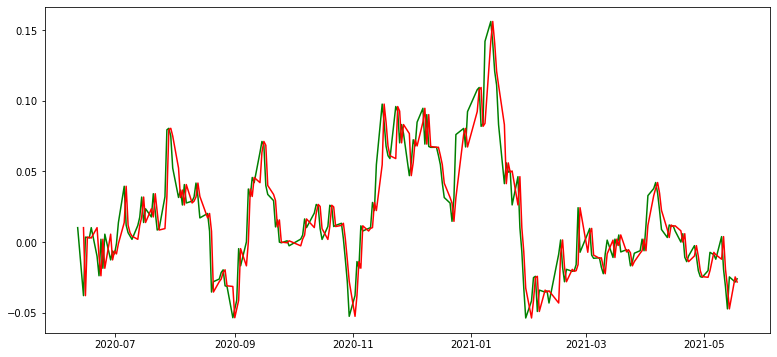

In [33]:
ts_log_moving_avg_shift = ts_log_moving_avg_20.shift()

plt.plot(ts_log_moving_avg_20, color='green')
plt.plot(ts_log_moving_avg_shift, color='red')

##### 2) 원본 시계열 - 시프트한 시계열 값 그래프로 표현  

ts_log_moving_avg_diff  
= 원본 - 시프트 값 
= 원본과 시프트의 차이  
= 하루당 변화량 (이 데이터는 하루마다 데이터가 구축되어있음)  

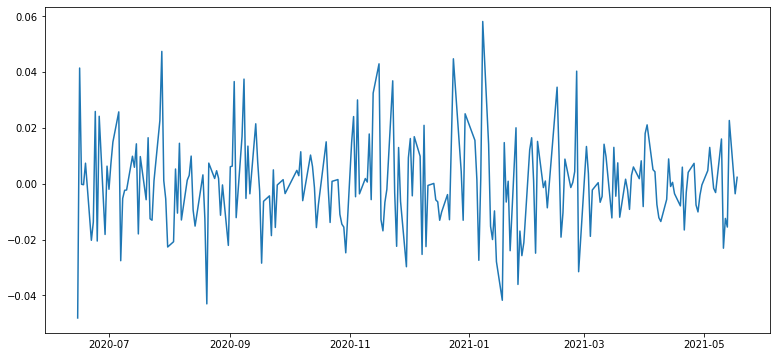

In [34]:
ts_log_moving_avg_diff = ts_log_moving_avg_20 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

##### 3) 이동 평균/표준편차 그래프로 표현  

정성적으로 안정성(stationary) 여부 파악

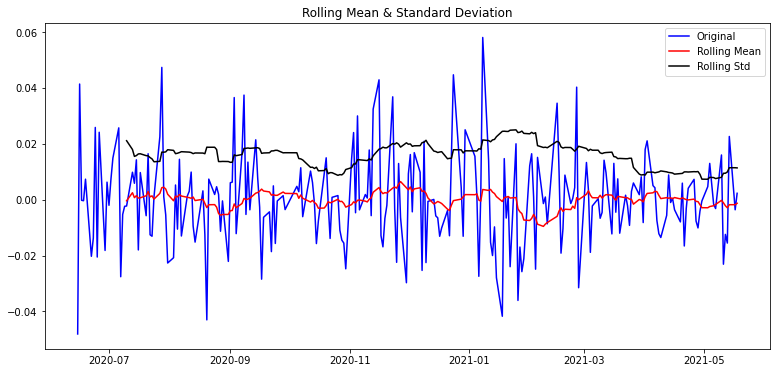

In [35]:
plot_rolling_statistics(ts_log_moving_avg_diff,window=20)

##### 4) 차분 적용된 ADF test 진행

In [36]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.583380e+01
p-value                        9.872810e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


- 추세=Trend 제거(=이동평균 뺀)한 난 시계열에  
  -> 1차 차분(1st order differencing)을 적용  
  -> 계절성 =Seasonality 효과 다소 상쇄  
  -> p-value =0.022 -> 0.0019 : 1/10 정도로 줄어듦  
  (2차 차분. 3차 차분 진행하면 더 p-value 낮출 수 있을것으로 기대)  
  
  
- 차분의 차수  
  1차 차분 = [x(t) – x(t-1)]  
  (d=1)은 현재 데이터와 이전 데이터의 차이  
  
  2차 차분 = [{x(t) – x(t-1)} – {x(t-1) – x(t-2)}]  
  (d=2)은 1차 차분 시계열을 한번 더 차분한 것
  
  정수 차원의 차분 시계열은 stationary한 특징이 있음  
  그러나 원 시계열이 가지고 있는 메모리를 지워 버림  
  차분 시계열을 다시 누적하면 원 시계열로 복원 ->메모리도 다시 복원  
  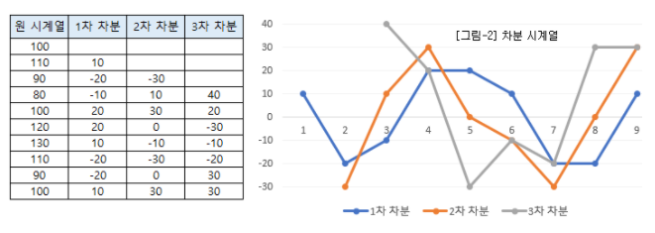 
  https://m.blog.naver.com/chunjein/222071363797  

### 3. 시계열 분해(Time series decomposition)

In [37]:
ts1_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

In [38]:
type(ts1_log.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [39]:
ts1[ts1.isna()] 

Series([], Name: Close, dtype: float64)

- statsmodels 라이브러리 내  
  seasonal_decompose 메소드  
  -> 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있는 기능 있음  
  -> moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리 가능  

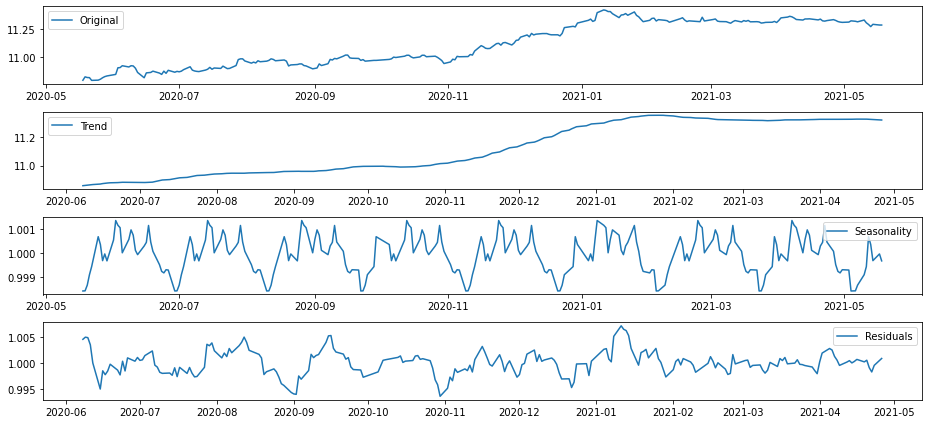

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts1_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

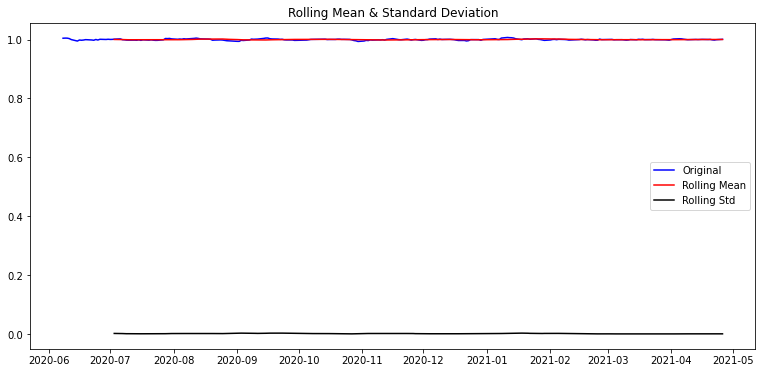

In [41]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual, window=20)

### 4. Residual 안정성 확인  

In [42]:
residual.isna().sum()

30

In [43]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


- p-value= 6.234854e-08로
  차분 진행보다는 조금 더 감소함  
  그러나 차분 더 진행해서 감소해야할 필요성 있음  

### STEP 4 : 학습, 테스트 데이터셋 생성  

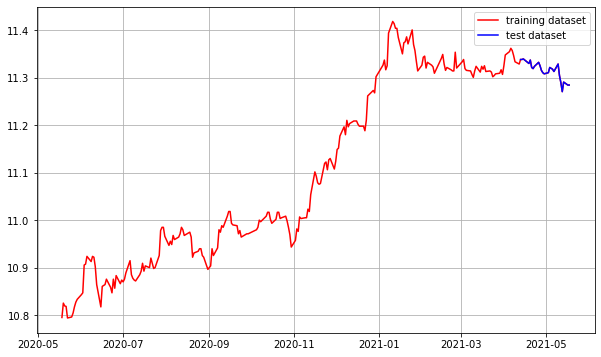

In [44]:
train_data, test_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기  


### ① ARIMA 모델의 모수(파라미터)  p, q, d  
- ARIMA 효과적으로 활용하려면  
  <- ARIMA의 모수(parameter)를 잘 설정해야함  
  

#### 1. ARIMA 의 모수 3가지  
  1) p : 자기회귀 모형(AR)의 시차 = 구간 1과 2의 차이= 변화량  
  2) q : 이동평균 모형(MA)의 시차  
  3) d : 차분누적(I) 횟수  
  
  -> 일반적으로 p + q < 2, p * q = 0 사용  
     p or q =0 이라는 뜻  
  -> 많은 시계열 데이터가 AR 또는 MA 중 하나의 경향만 가지기 때문  
  
  
#### 2. 모수 p,q,d의 결정 방법  
 - 통계학적인 많은 시도가 있었는데  
    -> 대표적인 방법 : ACF(Autocorrelation Function)와  
    PACF(Partial Autocorrelation Function)  

  - **1) ACF**  
    - 맨 첫 스텝에서 우리가 다룬 개념중 하나인 자기상관계수와 같은 것  
    - 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수  
    - 주어진 시계열의 현재 값이 과거(yt−1​ ,yt−2​ ,....,yt−n​)값과 어떻게 상관되는지 설명함  
    - ACF plot에서 x축= 상관계수, y축= 시차 수  
  - **2) PACF**  
    - 다른 관측치의 영향력을 배제하고  
      두 시차의 관측치 간 관련성을 측정하는 함수  
    - K 외 모든 시차를 갖는 관측치(yt−1​ ,yt−2​ ,....,yt−k+1​)의 영향력을 배제하고  
      이 중 두 관측치 yt와 yt-k가 얼마나 관련있는지 나타내는 척도  
    

#### 3. 참고자료  
  [자기상관함수 및 편자기상관함수](http://kanggc.iptime.org/em/chap9/chap9.pdf)  
  [A Gentle Introduction to Autocorrelation and Partial Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)  
  

### ②  ACF, PACF 그려보기 -> p,q 구하기  

ACF를 통해 MA 모델의 시차 q를 결정  
PACF를 통해 AR 모델의 시차 p를 결정  
-> ACF는 p를 따르니까 q의 영향을 받는거고  
-> PACF는 q를 따르니까 p의 영향을 받는거고  

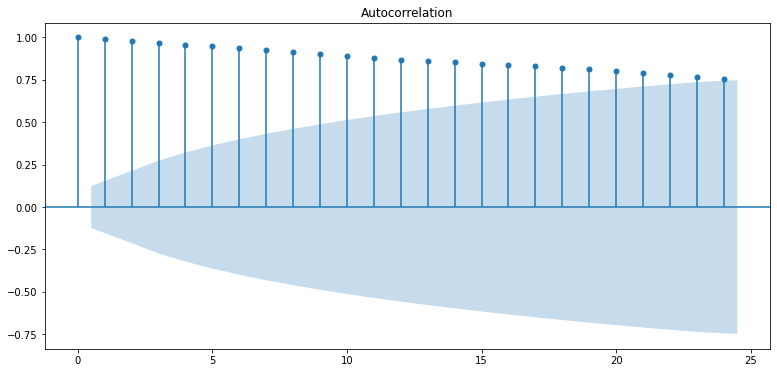

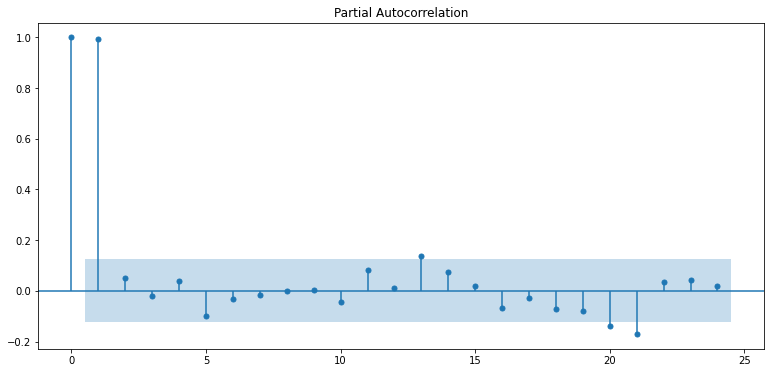

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


  - PACF 그래프 볼때 p=1 일때 매우 적합  
    <- p >= 2 구간에서는 PACF가 거의 0에 가까워지고 있기 때문  
    -> PACF =0 이라는 의미는  
    현재 데이터와 p시점 떨어진 이전의 데이터 상관도 =0  
    즉, 아무상관 없는 데이터니까 고려할 필요 없다는 것  
    
    
  - ACF는 점차적으로 감소하고 있음  
    -> AR(1) 모델에 유사한 형태를 보이고 있는 것  
    
    q에 대해 적합한 값이 없어 보임  
    -> MA 고려할 필요 없으면 q=0으로 둘 수 있음  
    -> 아니면 q 바꿔 가며 확인해보기 
    
    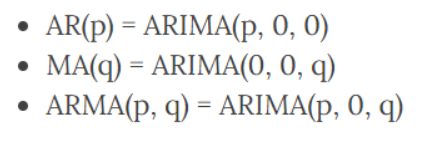


### ③ 차분 안정성 확인 -> d 구하기  

In [ ]:
# 1차 차분 구하기
diff_1 = ts1_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


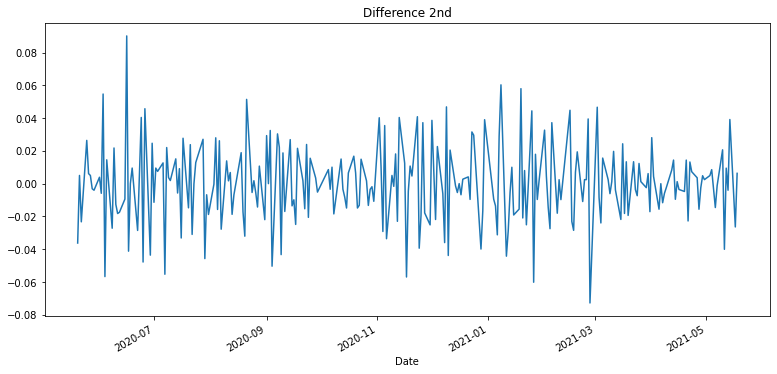

In [47]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2차 차분이 더 낮은 p-value 값을 가짐  
  1차 차분만 진행하는 것이 좋을 것 같음  

### STEP 6 : ARIMA 모델 훈련과 테스트  

### ① p= 1, d= 1, q= 0

#### 1)  ARIMA 모델 빌드와 훈련

In [51]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

# p= 1, d= 1, q= 0

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 19 Nov 2021   AIC                          -1164.792
Time:                        20:10:19   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

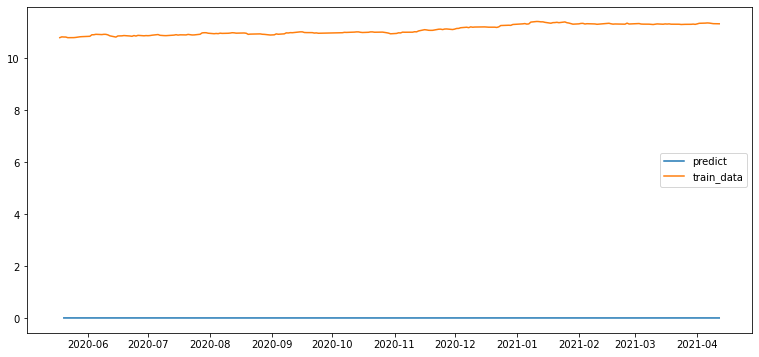

In [53]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

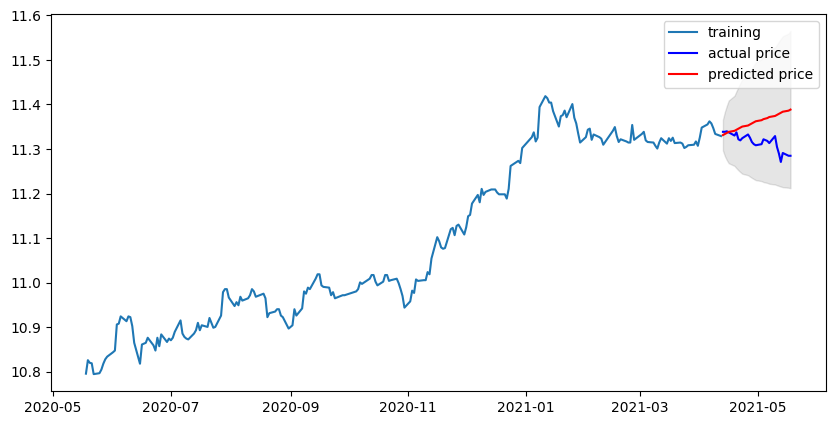

In [52]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


### ② p= 1, d= 2, q= 0

#### 1)  ARIMA 모델 빌드와 훈련

In [73]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 535.977
Method:                       css-mle   S.D. of innovations              0.022
Date:                Fri, 19 Nov 2021   AIC                          -1065.954
Time:                        20:23:53   BIC                          -1055.732
Sample:                             2   HQIC                         -1061.827
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0001      0.001     -0.118      0.906      -0.002       0.002
ar.L1.D2.Close    -0.4759      0.059     -8.067      0.000      -0.591      -0.360
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

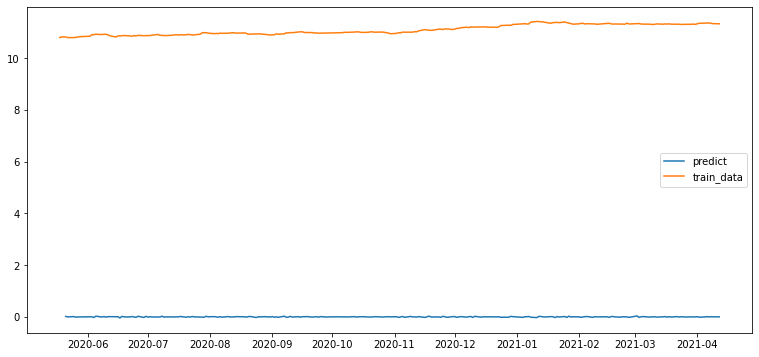

In [56]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

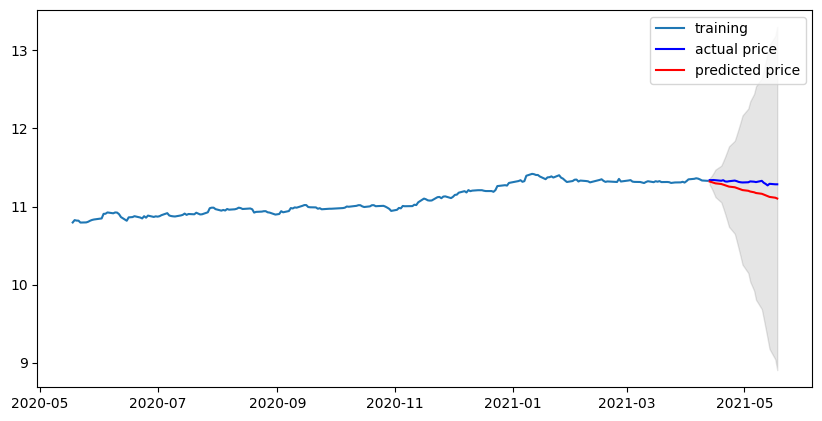

In [74]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [75]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  70754398.26831636
MAE:  7601.062623954185
RMSE:  8411.563366480475
MAPE: 9.32%


### ③ p= 1, d= 0, q= 0
#### 1)  ARIMA 모델 빌드와 훈련

In [76]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  225
Model:                     ARMA(1, 0)   Log Likelihood                 583.467
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 19 Nov 2021   AIC                          -1160.933
Time:                        20:23:59   BIC                          -1150.685
Sample:                             0   HQIC                         -1156.797
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0688      0.210     52.701      0.000      10.657      11.480
ar.L1.Close     0.9972      0.003    298.854      0.000       0.991       1.004
                                    Roots       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

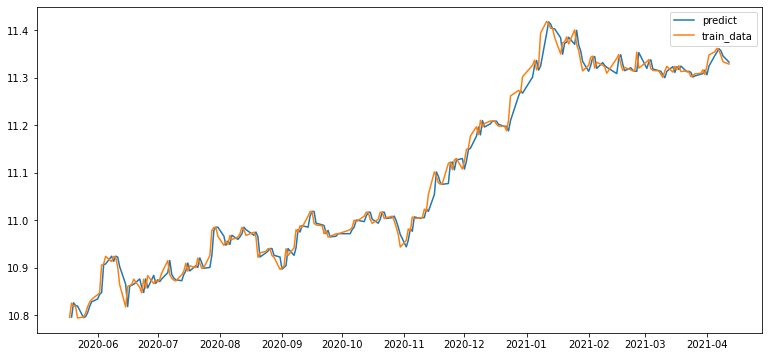

In [59]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

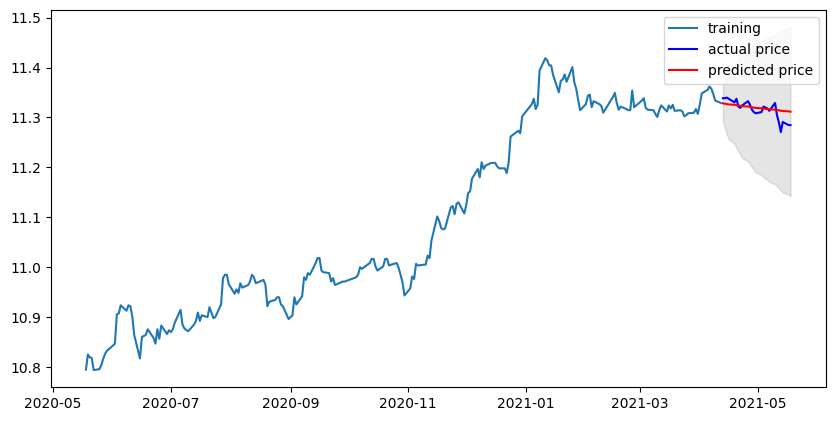

In [77]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1533430.4832786121
MAE:  957.802482046241
RMSE:  1238.3176019416878
MAPE: 1.18%


### ④ p= 0, d= 1, q= 1
#### 1)  ARIMA 모델 빌드와 훈련

In [79]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 585.398
Method:                       css-mle   S.D. of innovations              0.018
Date:                Fri, 19 Nov 2021   AIC                          -1164.796
Time:                        20:24:06   BIC                          -1154.561
Sample:                             1   HQIC                         -1160.664
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.977      0.048    2.02e-05       0.005
ma.L1.D.Close     0.0177      0.069      0.257      0.797      -0.117       0.153
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

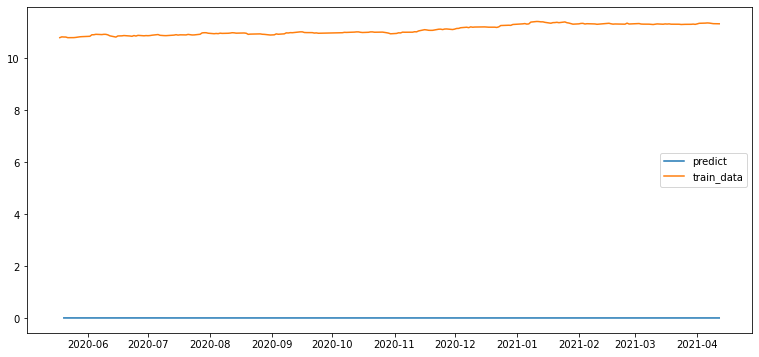

In [62]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

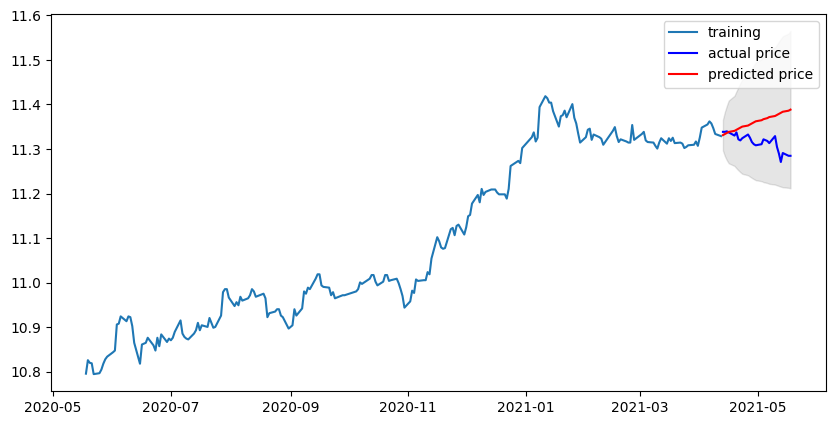

In [80]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22088457.65325718
MAE:  3791.4564135901687
RMSE:  4699.835917695125
MAPE: 4.68%


### STEP 7 학습 결론  
-
-

-----
### [비트코인 주가]
[BTC-USD](https://finance.yahoo.com/quote/BTC-USD?p=BTC-USD)

### STEP 1 : 시계열 데이터 준비  
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

- 종가(Close)만 사용  


#### 1. 데이터 불러오기

In [131]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/BTC-USD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

ts = df['Close']

print(type(ts))
ts.head(10)

<class 'pandas.core.series.Series'>


Date
2020-11-19    17817.089844
2020-11-20    18621.314453
2020-11-21    18642.232422
2020-11-22    18370.001953
2020-11-23    18364.121094
2020-11-24    19107.464844
2020-11-25    18732.121094
2020-11-26    17150.623047
2020-11-27    17108.402344
2020-11-28    17717.414063
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행  

#### 1. 결측치 처리

In [132]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

- 결측치 없음  

#### 2. 로그 변환
- 우리는 애초에 이 데이터가 안정적이지 않다는 귀무가설을 세움  
  그렇기 때문에 안정적인(Stationary) 데이터 가공해야함  
  
  
- 시간추이에 따라 분산이 점점 커지고 있을 것이기 때문에  
  로그함수로 변환해서 시간추이에 따른 분산을 일정하게 만듦  

In [133]:
# 로그 변환 시도 
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석  

#### 1. 정성적 그래프 분석

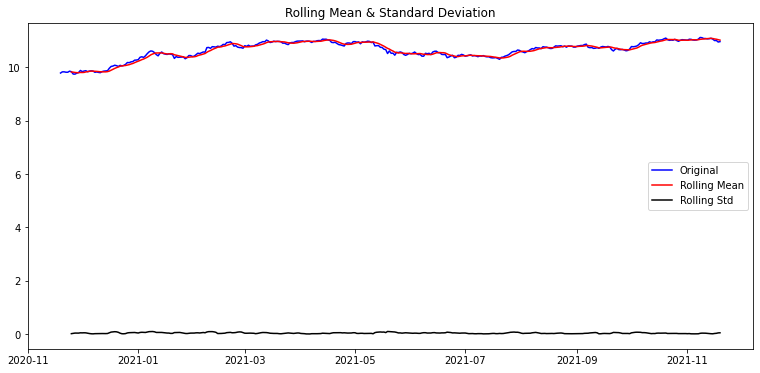

In [134]:
plot_rolling_statistics(ts_log, window=7)

#### 2. 정량적 Augmented Dicky-Fuller Test

In [135]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.366470
p-value                          0.151425
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64


 - p-value= 0.151425 낮은 수치라고 판단됨  
   -> 귀무가설 기각  
   -> 해당 데이터 안정적  

#### 3. 시계열 분해  

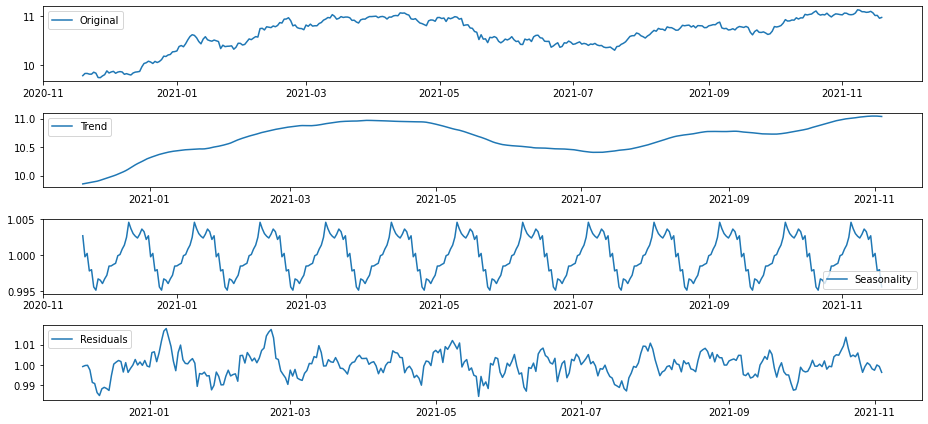

In [136]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


#### 4. Residual 안정성 확인  

In [137]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.231541e+00
p-value                        4.939635e-08
#Lags Used                     0.000000e+00
Number of Observations Used    3.350000e+02
Critical Value (1%)           -3.450022e+00
Critical Value (5%)           -2.870207e+00
Critical Value (10%)          -2.571387e+00
dtype: float64


- p-value 값 증가했지만, 차분 진행하면서 낮아질 것으로 기대  

### STEP 4 : 학습, 테스트 데이터셋 생성  

#### 1. 학습/테스트 데이터 분리  

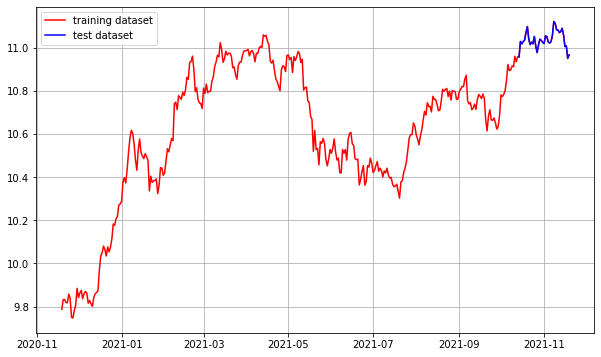

In [138]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기  

#### 1. ACF, PACF 그려보기 -> p,q 구하기

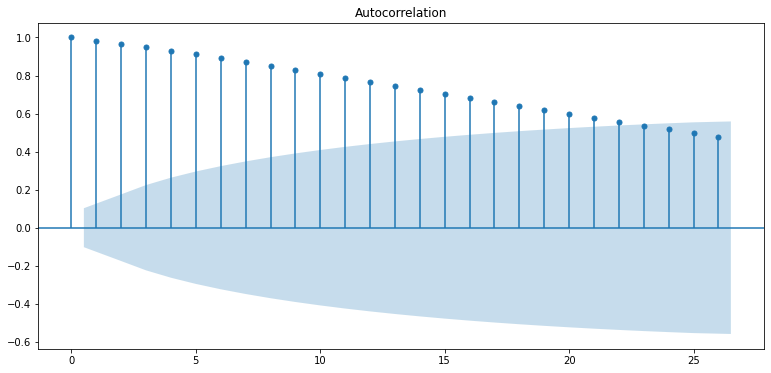

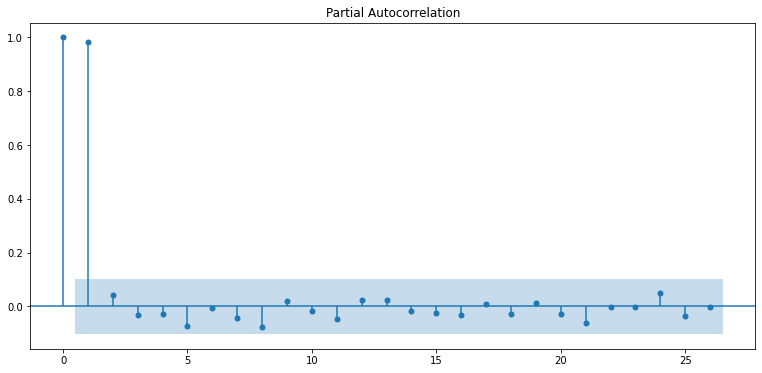

In [139]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


- q는 어느 값이여도 상관없어서 조정해가면서 학습 결과 비교하면 될것 같음  
  p는 2이상은 모두 0과 가까워지기 때문에 0 또는 1의 값으로 학습 진행  

#### 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                 -19.840265
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


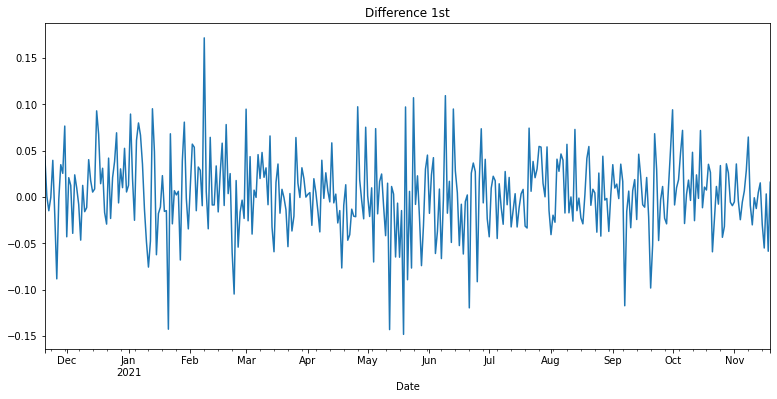

In [140]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.832252e+00
p-value                        1.756946e-14
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


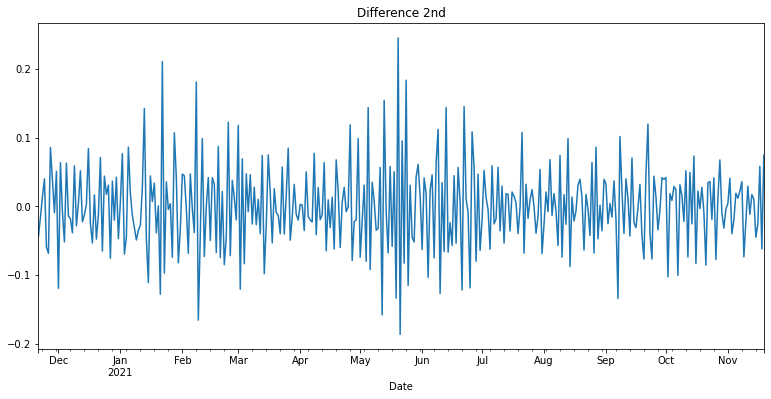

In [141]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 1차 차분일떼 p-value가 0과 아주 가까운 값 또는 0이 나오는 것 같음  
  비트코인이기 때문에 변동성이 너무 많고  
  때문에 계절성이 어쩌면 상쇄되지 않을수도 있다고 생각했는데  
  의외로 아주 안정화 되어 보임  

### STEP 6 : ARIMA 모델 훈련과 테스트  

### ① p= 1, d= 1, q= 0

#### 1. ARIMA 모델 빌드와 훈련  

In [142]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 564.368
Method:                       css-mle   S.D. of innovations              0.043
Date:                Fri, 19 Nov 2021   AIC                          -1122.735
Time:                        23:02:33   BIC                          -1111.356
Sample:                    11-20-2020   HQIC                         -1118.195
                         - 10-13-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0036      0.002      1.555      0.120      -0.001       0.008
ar.L1.D.Close    -0.0445      0.055     -0.807      0.420      -0.153       0.064
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


#### 2. 모델 테스트 및 플로팅

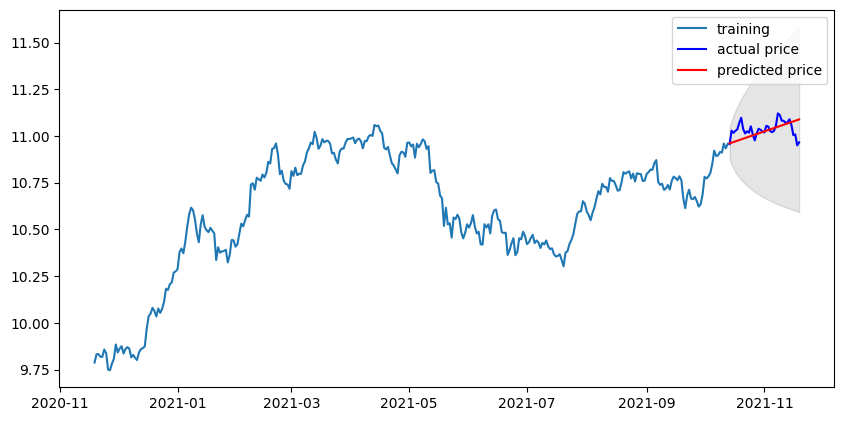

In [143]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


#### 3. 최종 예측 모델 정확도 측정(MAPE)

In [144]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10387890.718749337
MAE:  2396.579527178941
RMSE:  3223.025088135266
MAPE: 3.87%


#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  10387890.718749337
MAE:  2396.579527178941
RMSE:  3223.025088135266
MAPE: 3.87%


### ② p= 1, d= 2, q= 0

#### 1)  ARIMA 모델 빌드와 훈련

In [150]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  327
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 495.534
Method:                       css-mle   S.D. of innovations              0.053
Date:                Fri, 19 Nov 2021   AIC                           -985.068
Time:                        23:03:56   BIC                           -973.698
Sample:                    11-21-2020   HQIC                          -980.531
                         - 10-13-2021                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -6.86e-05      0.002     -0.036      0.972      -0.004       0.004
ar.L1.D2.Close    -0.5299      0.047    -11.316      0.000      -0.622      -0.438
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

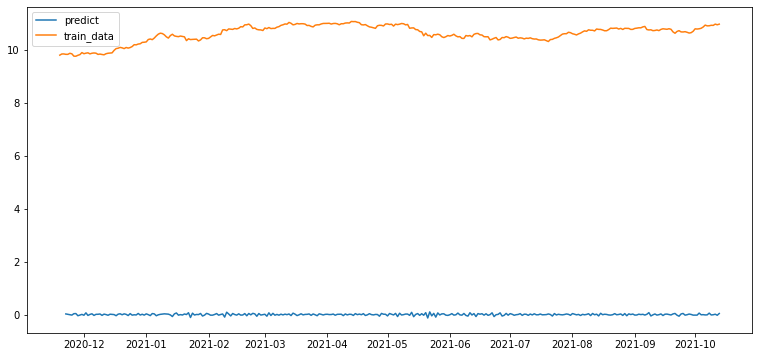

In [148]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

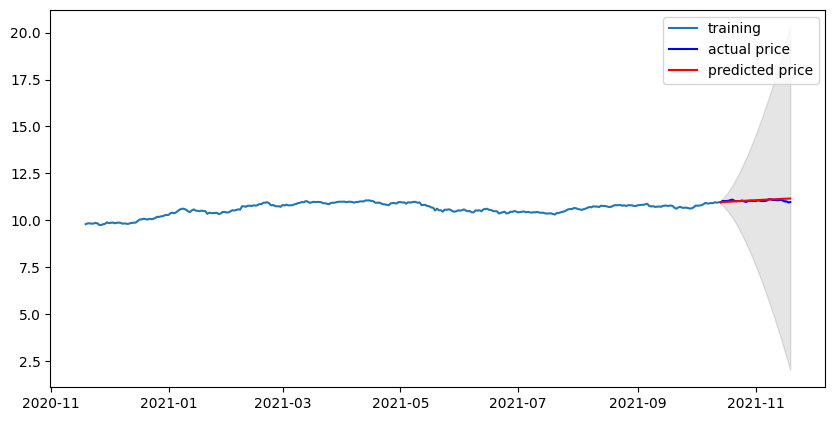

In [151]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  20705115.997612327
MAE:  3425.5964727973665
RMSE:  4550.287463184312
MAPE: 5.60%


### ③ p= 1, d= 0, q= 0
#### 1)  ARIMA 모델 빌드와 훈련

In [156]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  329
Model:                     ARMA(1, 0)   Log Likelihood                 562.490
Method:                       css-mle   S.D. of innovations              0.043
Date:                Fri, 19 Nov 2021   AIC                          -1118.981
Time:                        23:04:55   BIC                          -1107.592
Sample:                    11-19-2020   HQIC                         -1114.438
                         - 10-13-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          10.4663      0.357     29.333      0.000       9.767      11.166
ar.L1.Close     0.9956      0.005    211.002      0.000       0.986       1.005
                                    Roots       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

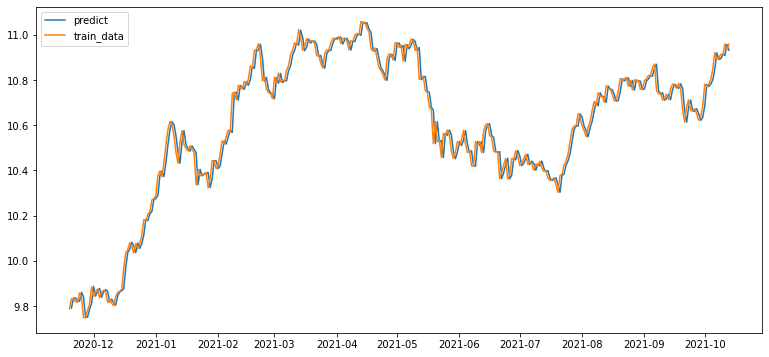

In [154]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

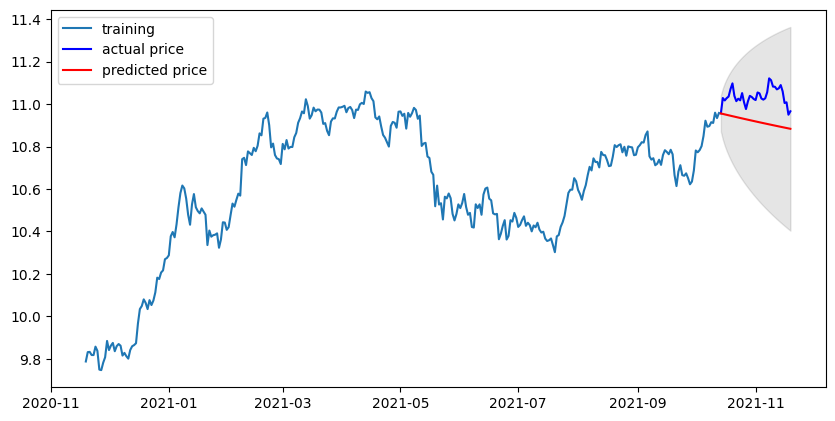

In [157]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [158]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  56138664.00406195
MAE:  6925.051485133124
RMSE:  7492.573923830311
MAPE: 11.00%


### ④ p= 0, d= 1, q= 1
#### 1)  ARIMA 모델 빌드와 훈련

In [161]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  328
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 564.355
Method:                       css-mle   S.D. of innovations              0.043
Date:                Fri, 19 Nov 2021   AIC                          -1122.710
Time:                        23:07:05   BIC                          -1111.331
Sample:                    11-20-2020   HQIC                         -1118.170
                         - 10-13-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0036      0.002      1.555      0.120      -0.001       0.008
ma.L1.D.Close    -0.0428      0.054     -0.793      0.428      -0.149       0.063
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

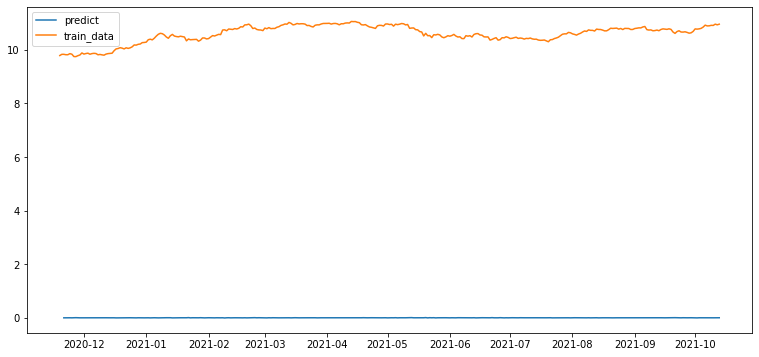

In [160]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

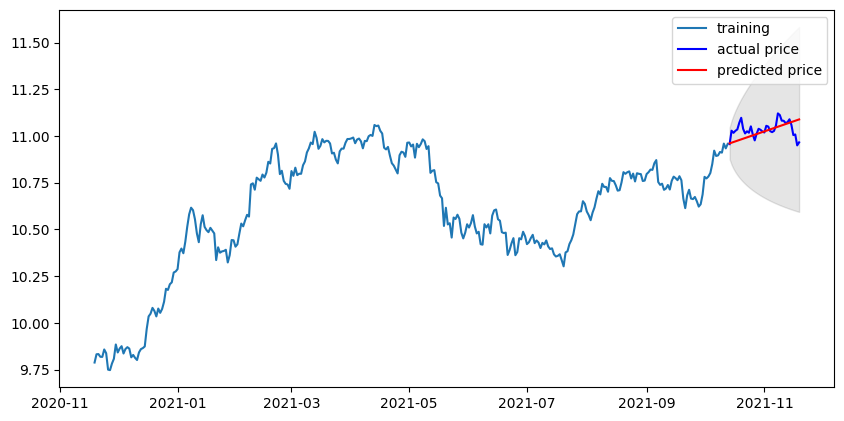

In [162]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [163]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  10384404.188824678
MAE:  2395.4927800351006
RMSE:  3222.484164247309
MAPE: 3.87%


### STEP 7 학습 결론  
최종적으로 **예측 모델의 메트릭으로 활용하기에 적당한 MAPE**  
MAPE 값이 적을수록 좋은데, 적게 나온것 같다고 판단됨

### [넷플릭스 주가]  

[NFLX](https://finance.yahoo.com/quote/NFLX?p=NFLX&.tsrc=fin-srch)

### STEP 1 : 시계열 데이터 준비  
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

- 종가(Close)만 사용  

#### 1. 데이터 불러오기

In [169]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

ts = df['Close']

print(type(ts))
ts.head(20)

<class 'pandas.core.series.Series'>


Date
2020-11-19    484.670013
2020-11-20    488.239990
2020-11-23    476.619995
2020-11-24    482.880005
2020-11-25    485.000000
2020-11-27    491.359985
2020-11-30    490.700012
2020-12-01    504.579987
2020-12-02    503.380005
2020-12-03    497.519989
2020-12-04    498.309998
2020-12-07    515.780029
2020-12-08    512.659973
2020-12-09    493.600006
2020-12-10    501.089996
2020-12-11    503.220001
2020-12-14    522.419983
2020-12-15    519.780029
2020-12-16    524.830017
2020-12-17    532.900024
Name: Close, dtype: float64

- 데이터 수집 날짜가  
  2,3,1,5,5,4 일 기간으로 수집되어서, window 지정이 조금 까다로울 수 도 있을 것 같음

### STEP 2 : 각종 전처리 수행  

#### 1. 결측치 처리

In [165]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

- 결측치 없음  

#### 2. 로그 변환
- 우리는 애초에 이 데이터가 안정적이지 않다는 귀무가설을 세움  
  그렇기 때문에 안정적인(Stationary) 데이터 가공해야함  
  
  
- 시간추이에 따라 분산이 점점 커지고 있을 것이기 때문에  
  로그함수로 변환해서 시간추이에 따른 분산을 일정하게 만듦  

In [166]:
# 로그 변환 시도 
ts_log = np.log(ts)

### STEP 3 : 시계열 안정성 분석  

#### 1. 정성적 그래프 분석

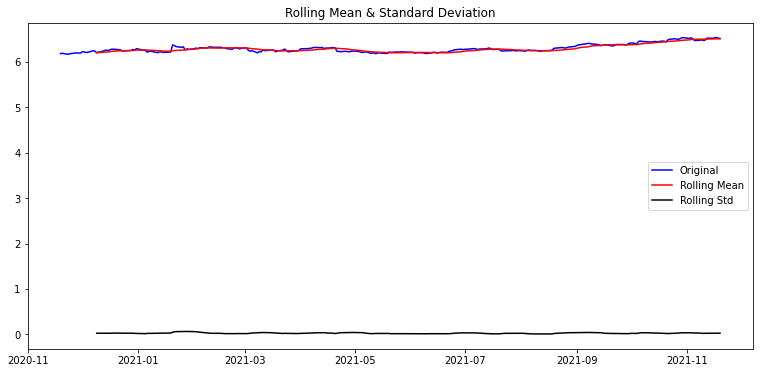

In [186]:
plot_rolling_statistics(ts_log, window=14)

#### 2. 정량적 Augmented Dicky-Fuller Test

In [184]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.392983
p-value                          0.911264
#Lags Used                       5.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


 - p-value= 0.911264 높은 수치라고 판단됨  
   -> 귀무가설 기각 어려움  
   -> 데이터 안정적이라고 판단하기 어려움 = 불안정한 데이터 같음  

#### 3. 시계열 분해  

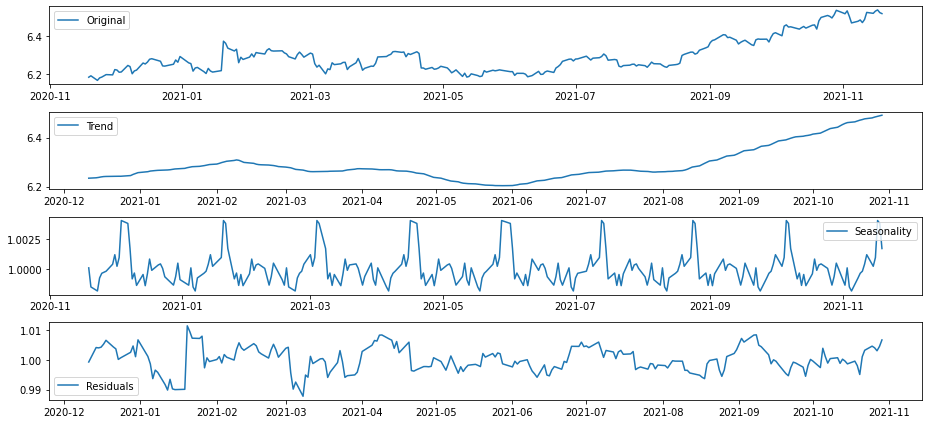

In [180]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### 4. Residual 안정성 확인  

In [181]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.659457e+00
p-value                        9.453280e-07
#Lags Used                     4.000000e+00
Number of Observations Used    2.180000e+02
Critical Value (1%)           -3.460708e+00
Critical Value (5%)           -2.874891e+00
Critical Value (10%)          -2.573886e+00
dtype: float64


 - p-value 도 여전히 높음  

### STEP 4 : 학습, 테스트 데이터셋 생성  

#### 1. 학습/테스트 데이터 분리  

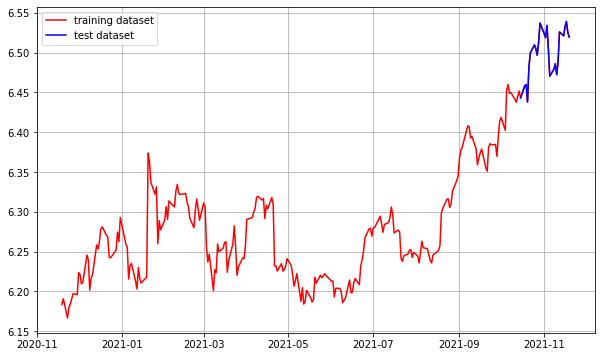

In [182]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기  

#### 1. ACF, PACF 그려보기 -> p,q 구하기

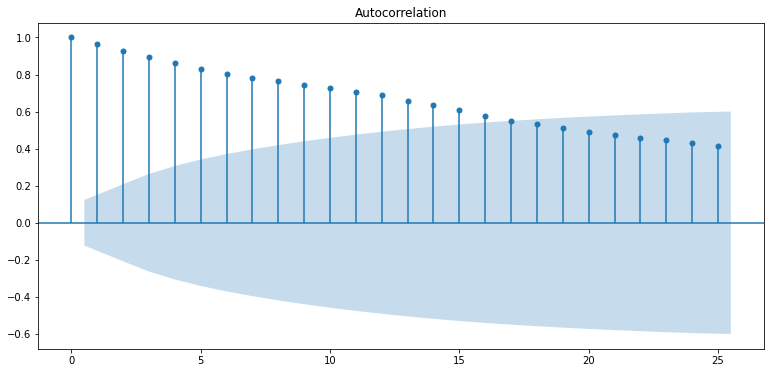

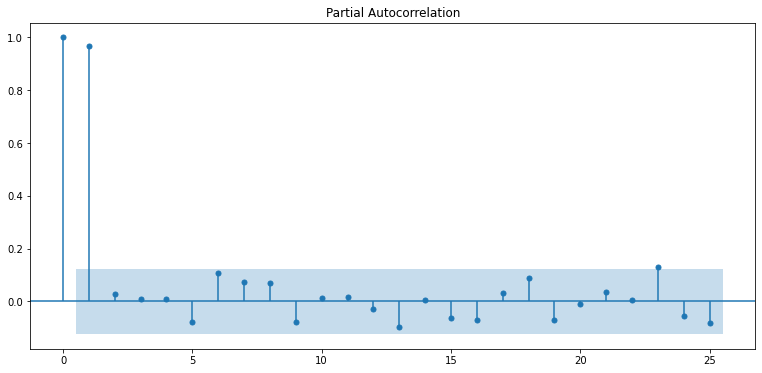

In [187]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


- q는 어느 값이여도 상관없어서 조정해가면서 학습 결과 비교하면 될것 같음  
  p는 2이상은 모두 0과 가까워지기 때문에 0 또는 1의 값으로 학습 진행  

#### 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -8.246550e+00
p-value                        5.534229e-13
#Lags Used                     4.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


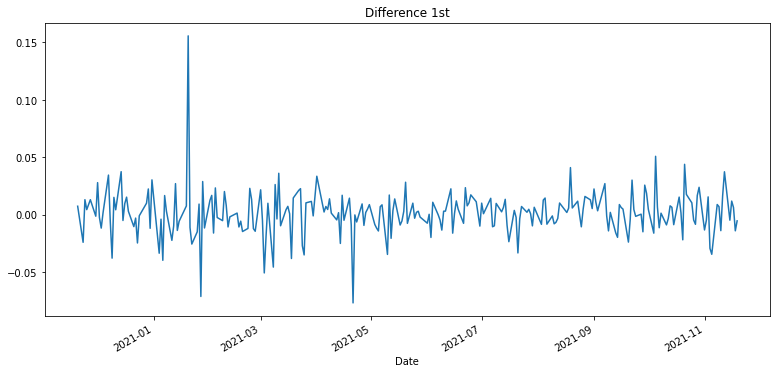

In [188]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.670591e+00
p-value                        1.597556e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


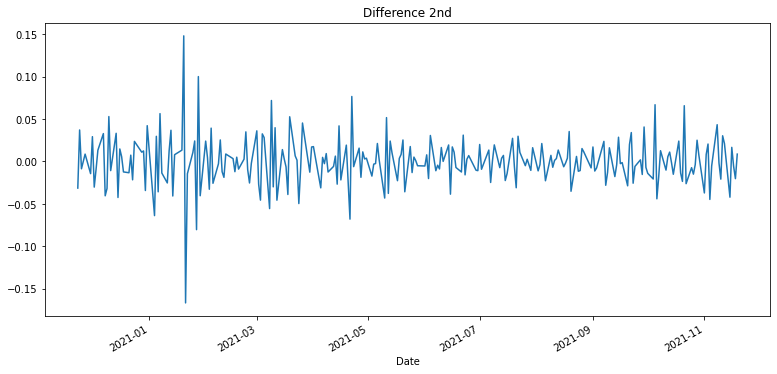

In [189]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 2차 차분일때가 훨씬더 p-value가 더 안정적으로 보인다

### STEP 6 : ARIMA 모델 훈련과 테스트  

### ① p= 1, d= 1, q= 0

#### 1. ARIMA 모델 빌드와 훈련  

In [190]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 563.536
Method:                       css-mle   S.D. of innovations              0.020
Date:                Fri, 19 Nov 2021   AIC                          -1121.072
Time:                        23:25:01   BIC                          -1110.810
Sample:                             1   HQIC                         -1116.931
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      0.964      0.335      -0.001       0.004
ar.L1.D.Close    -0.0842      0.066     -1.273      0.203      -0.214       0.045
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2. 모델 테스트 및 플로팅

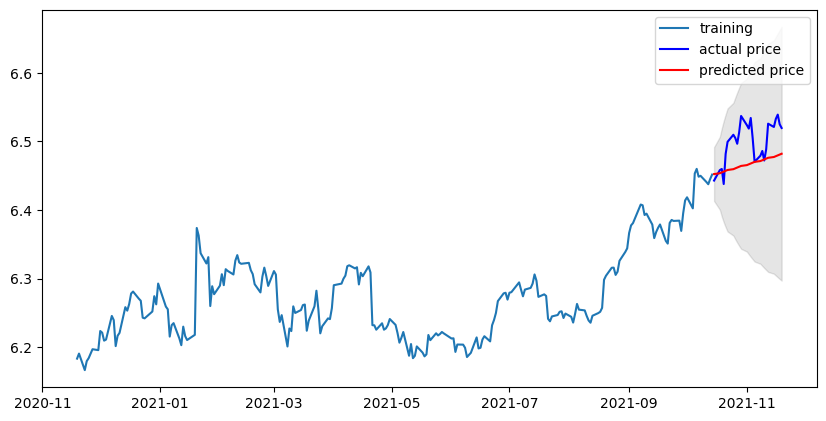

In [191]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 3. 최종 예측 모델 정확도 측정(MAPE)

In [192]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  719.9768884123818
MAE:  22.665212214596426
RMSE:  26.83238506753326
MAPE: 3.35%


#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [193]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  719.9768884123818
MAE:  22.665212214596426
RMSE:  26.83238506753326
MAPE: 3.35%


### ② p= 1, d= 2, q= 0

#### 1)  ARIMA 모델 빌드와 훈련

In [197]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 505.029
Method:                       css-mle   S.D. of innovations              0.026
Date:                Fri, 19 Nov 2021   AIC                          -1004.057
Time:                        23:26:11   BIC                           -993.809
Sample:                             2   HQIC                          -999.921
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.439e-05      0.001      0.039      0.969      -0.002       0.002
ar.L1.D2.Close    -0.5000      0.058     -8.675      0.000      -0.613      -0.387
                                    

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

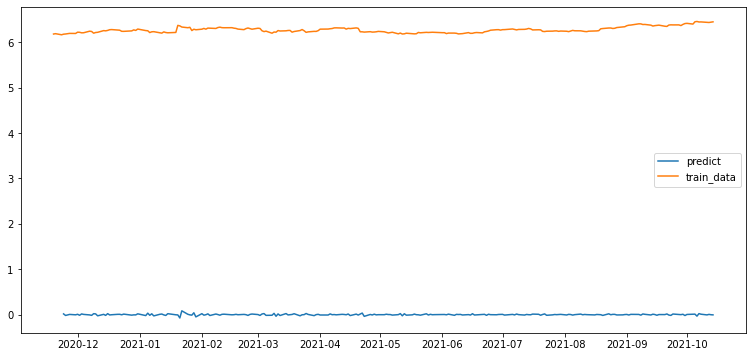

In [195]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

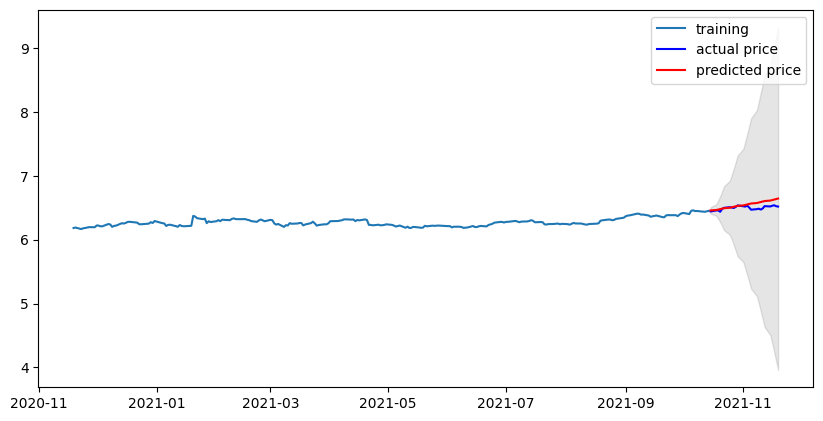

In [198]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [199]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2277.172781296461
MAE:  36.29856275318676
RMSE:  47.719731571923795
MAPE: 5.44%


### ③ p= 1, d= 0, q= 0
#### 1)  ARIMA 모델 빌드와 훈련

In [203]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  227
Model:                     ARMA(1, 0)   Log Likelihood                 564.857
Method:                       css-mle   S.D. of innovations              0.020
Date:                Fri, 19 Nov 2021   AIC                          -1123.714
Time:                        23:27:02   BIC                          -1113.439
Sample:                             0   HQIC                         -1119.568
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.2834      0.035    179.735      0.000       6.215       6.352
ar.L1.Close     0.9659      0.019     50.709      0.000       0.929       1.003
                                    Roots       

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

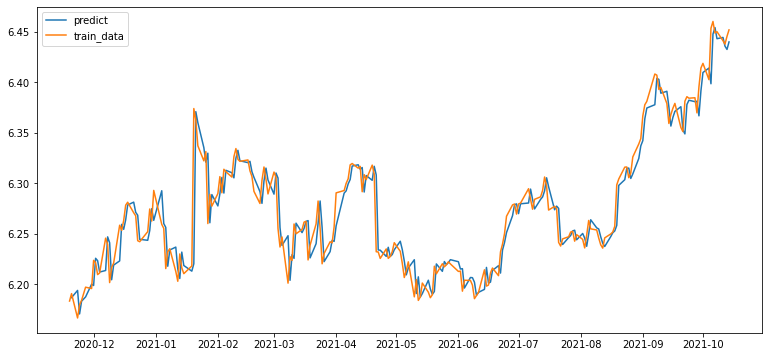

In [201]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

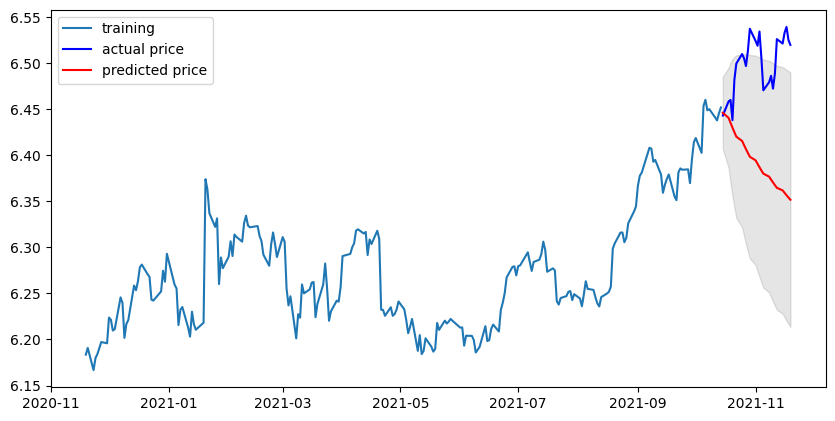

In [204]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [205]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5610.36137386122
MAE:  67.67983648306631
RMSE:  74.90234558317397
MAPE: 10.06%


### ④ p= 0, d= 1, q= 1
#### 1)  ARIMA 모델 빌드와 훈련

In [209]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 563.717
Method:                       css-mle   S.D. of innovations              0.020
Date:                Fri, 19 Nov 2021   AIC                          -1121.433
Time:                        23:28:05   BIC                          -1111.171
Sample:                             1   HQIC                         -1117.292
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.001      0.992      0.321      -0.001       0.004
ma.L1.D.Close    -0.1033      0.073     -1.413      0.158      -0.247       0.040
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


#### 2) ARIMA 훈련 결과 시각화

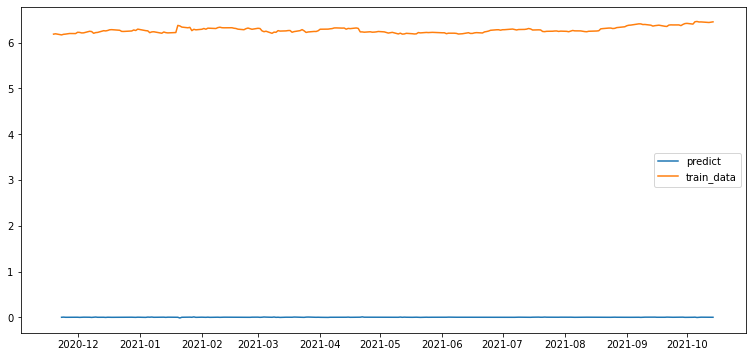

In [207]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

#### 3) 모델 테스트 및 플로팅  
테스트 데이터 구간데이터 예측  
forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측  

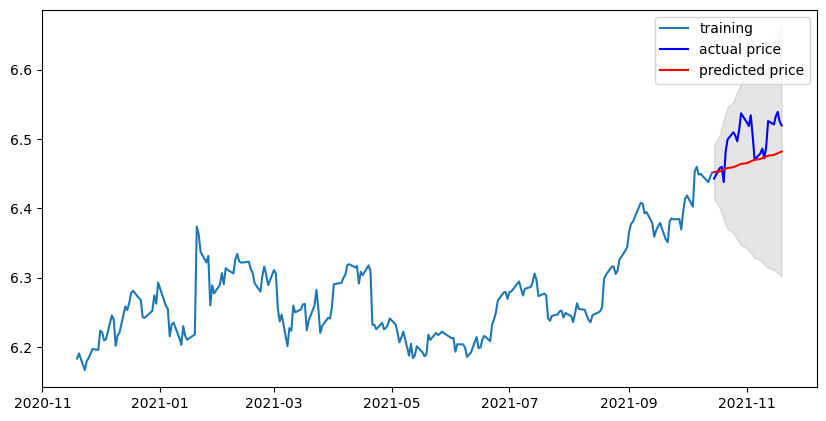

In [210]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

#### 4) 지수 변환  
시계열 데이터를 로그 변환하여 사용했었음  
-> 다시 지수 변환해야 정확한 오차 계산 가능  

exp() 로 원본 스케일로 되돌린 후에  
-> MSE, MAE, RMSE, MAPE 계산  

In [211]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  725.5828004804948
MAE:  22.766993510256743
RMSE:  26.936644194860182
MAPE: 3.37%


### STEP 7 학습 결론  
최종적으로 **예측 모델의 메트릭으로 활용하기에 적당한 MAPE**  
MAPE 값이 적을수록 좋은데, 적게 나온것 같다고 판단됨

### 회고  

#### 💚어려웠던 점  
-  window size 설정  
   노드 공부하면서 다뤘던 데이터는 데이터 승객, 온도변화에 대한 데이터 였어서  
   데이터 분석가의 시각으로 보거나, 시각화된 데이터를 보면서  
   주기성이 12달 단위로 형성될 것을 예측하여 설정할수 있었음  
   하지만 주식 데이터는 시각화를 해도  
   주기성을 가진 구간을 설정하기 쉽지 않았음  

#### 💚따로 공부한 부분  
##### 1) 처음엔 주기성과 계절성의 차이점을 이해하기 어려웠음  
  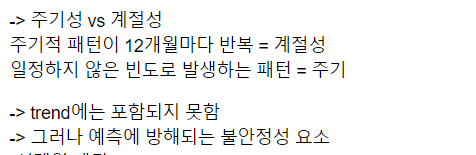
   
   
##### 2) 1, 2차 차분이 무엇을 의미하는 가  
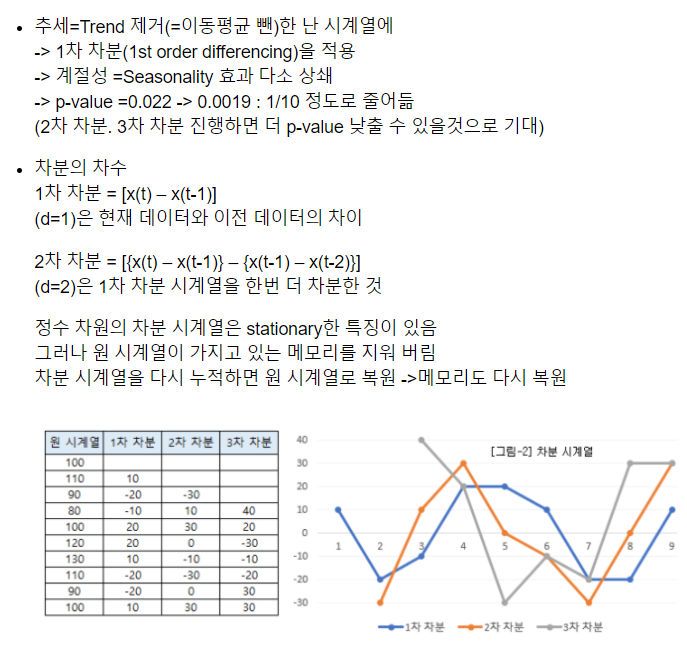

#### 💚개선하고 싶은점  
##### 1) 시각화  
그래프 그리기 std 그래프가 너무 차이가 많이나서  
  그래프 시각화가 잘 안되고 있는데   
  이를 개선시킬 수 있는 방법을 고안해볼것  
  시간이 없어서 진행해보지는 못함  
  추후 그래프 시각화와 함수 구현에 대한 능력이 발현되길 바람 ㅠ  
  
##### 2) MSE, MAE, RMSE, MAPE  
MAPE 수치를 보고 데이터를 판단했는데  
이에 대한 각 수치들이 뜻하는 의미를 아직 제대로 공부하지 못했음  
알아보니까 통계학적 지식이 백그라운드로 좀 필요하길래  
공부하다가 다 이해못했음  
나중에 본 의미를 판단할 수 있기를 ㅠ